What we need is a small parcel to work on, with a nice contourplot with critical points and minima found after initiating local method and then a 3d plot. 

In [1]:
using Globtim
include("../src/lib_func.jl")

# Constants and Parameters
d = 20 # Initial Degree 
const n, a, b = 2, 10, 1 
const scale_factor = a / b       # Scaling factor appears in `main_computation`, maybe it should be a parameter.
const delta, alpha = .9 , 8 / 10  # Sampling parameters
const tol_l2 = 3e-2             # Define the tolerance for the L2-norm

f = HolderTable # Objective function

HolderTable (generic function with 1 method)

We need to also return the number of samples used to generate the sample set. It is annoying that the error goes up while the degree has increased.

In [2]:
while true # Potential infinite loop
    global poly_approx = MainGenerate(f, 2, d, delta, alpha, scale_factor, 0.2) # computes the approximant in Chebyshev basis
    if poly_approx.nrm < tol_l2
        println("attained the desired L2-norm: ", poly_approx.nrm)
        break
    else
        println("current L2-norm: ", poly_approx.nrm)
        println("Number of samples: ", poly_approx.N)
        global d += 1
    end
end

attained the desired L2-norm: 0.013964267233460474


We now expand the approximant computed in the tensorized Chebyshev basis into standard monomial basis.

In [3]:
using DynamicPolynomials, HomotopyContinuation, ProgressLogging, DataFrames
@polyvar(x[1:n]) # Define polynomial ring 
ap = main_nd(n, d, poly_approx.coeffs) 
# Expand the polynomial approximant to the standard monomial basis in the Lexicographic order w.r.t x. 
PolynomialApproximant = sum(Float64.(ap) .* MonomialVector(x, 0:d)) # Convert coefficients to Float64 for homotopy continuation
grad = differentiate.(PolynomialApproximant, x)
sys = System(grad)

System of length 2
 2 variables: x₁, x₂

 1.9601441763654e-14 - 388.489889108612*x₁ - 5.30954542150037e-15*x₂ + 6.19339436210508e-13*x₂*x₁ + 9.1971923436635e-13*x₂*x₁^2 - 7.02787599586653e-12*x₂*x₁^3 - 1.22851659719649e-11*x₂*x₁^4 - 4.84201472141782e-13*x₂*x₁^5 + 6.53660551208953e-11*x₂*x₁^6 + 1.25826495020513e-10*x₂*x₁^7 - 1.90980376189417e-10*x₂*x₁^8 - 3.60754027787615e-10*x₂*x₁^9 + 3.24613116996215e-10*x₂*x₁^10 + 4.43565636416771e-10*x₂*x₁^11 - 2.89904990434143e-10*x₂*x₁^12 - 2.95234784210361e-10*x₂*x₁^13 + 7.97608566357581e-11*x₂*x₁^14 + 1.07982072277542e-10*x₂*x₁^15 + 5.22147269082615e-11*x₂*x₁^16 - 1.3375693450831e-11*x₂*x₁^17 - 2.96217980988032e-11*x₂*x₁^18 + 2271.98163464647*x₂^2*x₁ + 3.29086499868711e-12*x₂^2*x₁^2 - 29942.1135441264*x₂^2*x₁^3 - 5.41574294199664e-11*x₂^2*x₁^4 - 31172.5768116551*x₂^2*x₁^5 + 5.34854018981671e-10*x₂^2*x₁^6 + 1570354.51880879*x₂^2*x₁^7 - 2.61601677082088e-09*x₂^2*x₁^8 - 7734244.81544113*x₂^2*x₁^9 + 6.59347820877381e-09*x₂^2*x₁^10 + 17696178.3232648

Solve the system of partial derivatives using HomotopyContinuation. Note that without the conversion to floating point coefficients, there is an issue if we try to use BigFloats directly. 

In [4]:
Real_sol_lstsq = HomotopyContinuation.solve(sys)
real_pts = HomotopyContinuation.real_solutions(Real_sol_lstsq; only_real=true, multiple_results=false)

Computing mixed cells... 2    Time: 0:00:00
Computing mixed cells... 14    Time: 0:00:00
  mixed_volume:  361


Tracking 361 paths...   1%|▏                            |  ETA: 1:08:25



Tracking 361 paths...  32%|█████████▍                   |  ETA: 0:00:51



Tracking 361 paths...  46%|█████████████▍               |  ETA: 0:00:29



Tracking 361 paths...  59%|█████████████████            |  ETA: 0:00:17



Tracking 361 paths...  74%|█████████████████████▍       |  ETA: 0:00:09



Tracking 361 paths...  89%|██████████████████████████   |  ETA: 0:00:03



Tracking 361 paths... 100%|█████████████████████████████| Time: 0:00:25
  # paths tracked:                  361
  # non-singular solutions (real):  361 (221)
  # singular endpoints (real):      0 (0)
  # total solutions (real):         361 (221)


221-element Vector{Vector{Float64}}:
 [-0.9434858327984544, -0.9659265267633287]
 [-0.308505118867127, 1.0146774414069089]
 [-0.9465878464689738, 0.15410709157024552]
 [0.15628652942638419, 1.0131021905196003]
 [0.6048758864651884, 0.6476951277420885]
 [-0.9911115419481062, 2.248073958027672e-16]
 [-0.8363543179267259, 0.46767203056860884]
 [4.0710550778334376e-18, 1.00504792350421]
 [0.31588763245061696, 0.9542423114345346]
 [0.9474965359474032, 0.32343008369549164]
 ⋮
 [-0.31318712890152034, 3.424451239442648e-16]
 [-0.30862681102735423, -0.1823004157783614]
 [8.821578100106496e-18, 0.7728681984147582]
 [5.0455474680768125e-17, 6.416619169391671e-16]
 [0.9954276341904581, 0.47562761371345674]
 [0.31860384608305004, 0.7797948720354443]
 [0.30862681102735406, 0.18230041577836212]
 [0.9455194712055585, -0.7863796264718538]
 [0.15117700276020185, 0.17270053023391588]

Sort through the critical points, make sure they fall into the domain of definition. Make them into a Dataframe.

In [5]:
condition(point) = -1 < point[1] < 1 && -1 < point[2] < 1
filtered_points = filter(condition, real_pts) # Filter points using the filter function
# Colllect the critical points of the approximant 
h_x = Float64[point[1] for point in filtered_points] # Initialize the x vector for critical points of approximant
h_y = Float64[point[2] for point in filtered_points] # Initialize the y vector
h_z = map(p -> f([p[1], p[2]]), zip(scale_factor * h_x, scale_factor * h_y))
df = DataFrame(x=scale_factor * h_x, y=scale_factor * h_y, z= h_z) # Create a DataFrame

207×3 DataFrame
 Row │ x             y             z            
     │ Float64       Float64       Float64      
─────┼──────────────────────────────────────────
   1 │ -9.43486      -9.65927      -0.265286
   2 │ -9.46588       1.54107      -0.00951235
   3 │  6.04876       6.47695      -1.4081
   4 │ -9.91112       2.24807e-15  -4.03182
   5 │ -8.36354       4.67672      -0.241854
   6 │  3.15888       9.54242      -0.15483
   7 │  9.47497       3.2343       -0.444917
   8 │ -3.15888       9.54242      -0.15483
  ⋮  │      ⋮             ⋮             ⋮
 201 │  8.82158e-17   7.72868      -4.74766e-17
 202 │  5.04555e-16   6.41662e-15  -1.37152e-15
 203 │  9.95428       4.75628      -0.273135
 204 │  3.18604       7.79795      -0.0133692
 205 │  3.08627       1.823        -0.0158878
 206 │  9.45519      -7.8638       -0.00550417
 207 │  1.51177       1.72701      -0.203322
                                192 rows omitted

In [6]:
using PlotlyJS, Colors
# Generate the grid and evaluate the function
N = 100  # resolution of the grid
x = range(-scale_factor, scale_factor, length=N)
y = range(-scale_factor, scale_factor, length=N)
z = [f([xi, yi]) for yi in y, xi in x]

100×100 Matrix{Float64}:
 -15.1402    -9.69806  -4.33274  -0.750282  …  -4.33274   -9.69806  -15.1402
 -16.0588   -10.2817   -4.59133  -0.794684     -4.59133  -10.2817   -16.0588
 -16.2499   -10.3992   -4.64159  -0.803        -4.64159  -10.3992   -16.2499
 -15.7692   -10.0868   -4.5      -0.778128     -4.5      -10.0868   -15.7692
 -14.6934    -9.39415  -4.18898  -0.723993     -4.18898   -9.39415  -14.6934
 -13.1156    -8.38136  -3.73554  -0.645306  …  -3.73554   -8.38136  -13.1156
 -11.1402    -7.11551  -3.1698   -0.547302     -3.1698    -7.11551  -11.1402
  -8.87772   -5.66766  -2.52356  -0.435503     -2.52356   -5.66766   -8.87772
  -6.44061   -4.10975  -1.82898  -0.315476     -1.82898   -4.10975   -6.44061
  -3.93839   -2.51184  -1.11729  -0.19262      -1.11729   -2.51184   -3.93839
   ⋮                                        ⋱                       
  -6.44061   -4.10975  -1.82898  -0.315476     -1.82898   -4.10975   -6.44061
  -8.87772   -5.66766  -2.52356  -0.435503     -2.52356

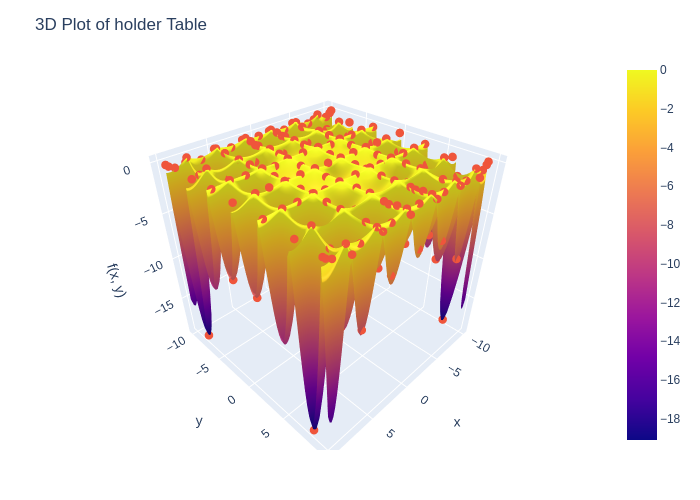

In [7]:
sf = surface(x=x, y=y, z=z)
# Had to switch the coordinates of the critical points to match the surface plot for some reason. 
crit_pts = scatter3d(x=df.y, y=df.x, z=df.z, mode="markers", marker_size=5, name="Critical Points")

# Layout for the plot
layout = Layout(title="3D Plot of holder Table",
    scene=attr(
        xaxis_title="x",
        yaxis_title="y",
        zaxis_title="f(x, y)"),
        height=800
)
# Display the plot layout,
plt = plot([sf, crit_pts], layout)

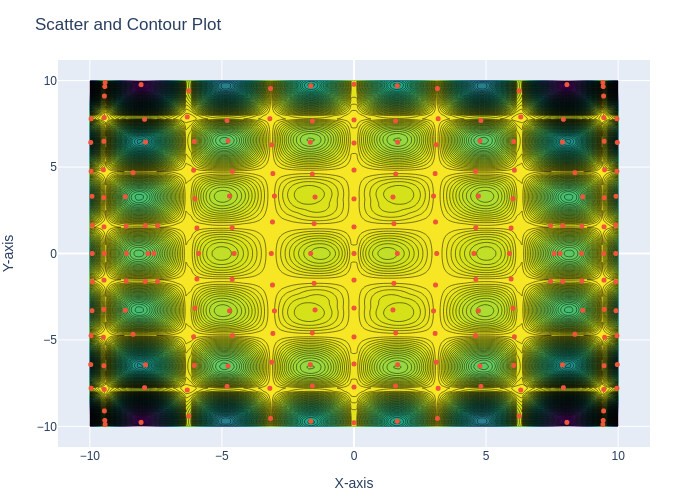

In [8]:
#Scatter plot the critical points of the approximant
scatter_traces = [scatter(x=df.x, y=df.y, mode="markers", marker_size=5, name="Critical Points")]

# Create the contour plot
cp = contour(x=x, y=y, z=z, ncontours=100, colorscale="Viridis", showscale=false)

# Combine contour plot and scatter traces
all_traces = [cp; scatter_traces...]

# Customize layout to handle legend groups
layout = Layout(
    title="Scatter and Contour Plot",
    xaxis_title="X-axis",
    yaxis_title="Y-axis",
    legend=(tracegroupgap=10, groupclick="toggleitem"),
    height=800 # Increase the height to make room for the legend 
)

# Display the combined plot with legend
display(plot(all_traces, layout))